**<h3><center>EN2550 Exercise 5 - Blobs and Fitting Basics</center></h3>**
*Name - Abeysinghe W.A.M.S.Y*
<br>
*Index no - 190014F*
<br>

All the imports are done at the beginning. 

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

**Blobs**

**Q1**. Construct the scale-normalized Laplacian of Gaussian (LoG) with σ = 10. Choose the
window size appropriately. Show this LoG as an image.

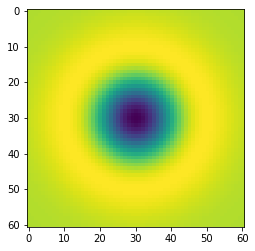

In [12]:
sigma = 10
hw = 3 * sigma
X, Y = np.meshgrid(np.arange(-hw, hw+1, +1), np.arange(-hw, hw+1, +1))
log = 1/(2*np.pi*sigma**2)*(X**2/(sigma**2) + Y**2/(sigma**2) - 2)*np.exp(-(X**2 + Y**2)/(2*sigma**2))

plt.imshow(log)
plt.show()

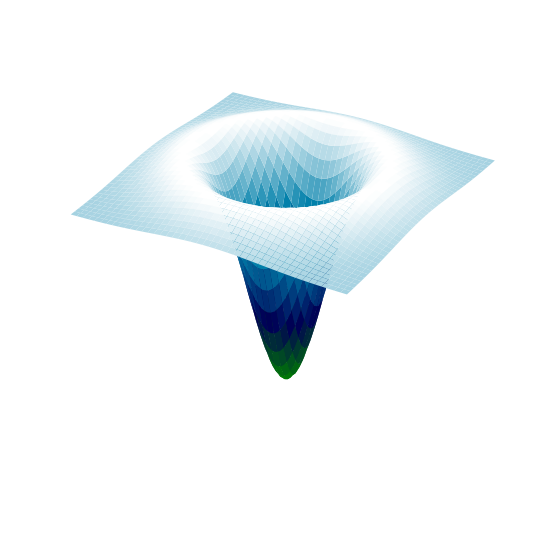

In [23]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(X,Y, log, cmap=cm.ocean, linewidth = 0, antialiased=True)

ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
plt.axis('off')
plt.show()

**Q2**. Filter a 71×71 image of a black circle of radius r = 14 with a series of LoG kernels
with σ ∈ [5,15] and find the scale-space extremum. Justify your answer.

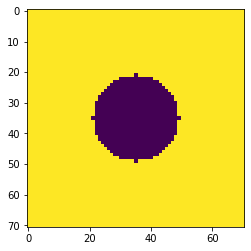

In [15]:
w, h = 71, 71
hw, hh = w//2, h//2

f = np.ones((h,w), dtype=np.float32)*255
X, Y = np.meshgrid(np.arange(-hh, hh+1, +1), np.arange(-hw, hw+1, +1))

r = w//5
f *= X**2 + Y**2 > r**2

plt.imshow(f)
plt.show()

(35, 35, 5)
10


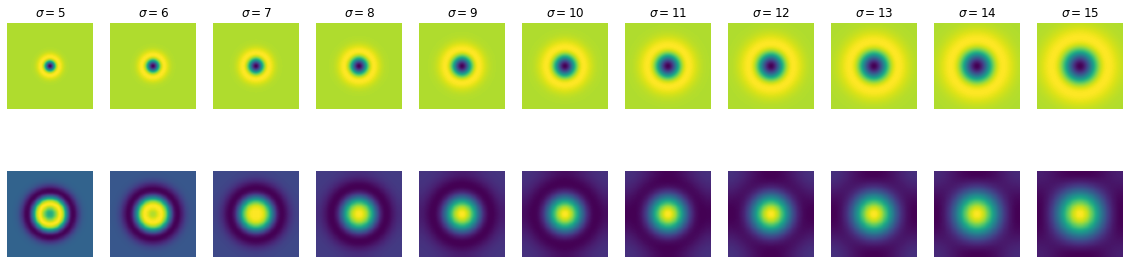

In [21]:
s = 11
fig, ax = plt.subplots(2, s, figsize=(20, 5))
scale_space = np.empty((h, w, s), dtype=np.float32)
sigmas = np.arange(5, 16, 1)
for i, sigma in enumerate(np.arange(5, 16, 1)):
  log_hw = 3*np.max(sigmas)
  X, Y = np.meshgrid(np.arange(-log_hw, log_hw+1, +1), np.arange(-log_hw, log_hw+1, +1))
  log = 1/(2*np.pi*sigma**2)*(X**2/(sigma**2) + Y**2/(sigma**2) - 2)*np.exp(-(X**2 + Y**2)/(2*sigma**2))
  f_log = cv.filter2D(f, -1, log)
  scale_space[:,:,i] = f_log
  ax[0, i].imshow(log)
  ax[0, i].axis('off')
  ax[0, i].set_title(r'$\sigma = {}$'.format(sigma))
  ax[1, i].imshow(f_log)
  ax[1, i].axis('off')


indices = np.unravel_index(np.argmax(scale_space, axis=None), scale_space.shape)
print(indices)
print(sigmas[indices[2]])

**Q3**. Match SIFT features between two images in the Graffiti sequence https://www.robots.ox.ac.uk/vgg/data/affine/.

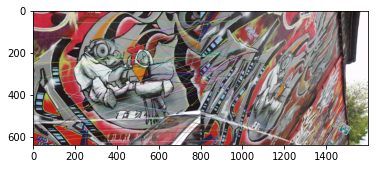

In [37]:
img1 = cv.imread('img1.ppm')  
img2 = cv.imread('img6.ppm') 

img1 = cv.cvtColor(img1, cv.COLOR_BGR2RGB)
img2 = cv.cvtColor(img2, cv.COLOR_BGR2RGB)

sift = cv.SIFT_create()

keypoints_1, descriptors_1 = sift.detectAndCompute(img1,None)
keypoints_2, descriptors_2 = sift.detectAndCompute(img2,None)

bf = cv.BFMatcher(cv.NORM_L1, crossCheck=True)

matches = bf.match(descriptors_1,descriptors_2)
matches = sorted(matches, key = lambda x:x.distance)

img3 = cv.drawMatches(img1, keypoints_1, img2, keypoints_2, matches[:50], img2, flags=2)
plt.imshow(img3)
plt.show()

**Fitting Basics**

**Q4**. The following is a code snippet to generate a noisy line. Use least-squares line fitting
to fit a line.

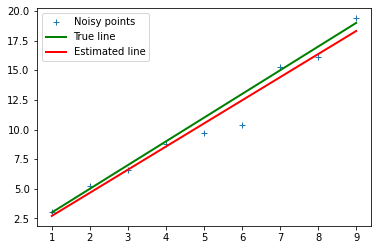

In [27]:
m = 2 # Line equation : y = m*x + c . m i s the s lope . c i s the int e r c ept .
c = 1
x = np . arange (1 ,10 , 1)
np.random.seed(45)
sigma = 1
noise = sigma*np.random.randn(len(x))
o = np.zeros(x.shape)
# o[=1] = 20
y = m*x + c + noise + o

n = len(x)
X = np.concatenate([x.reshape(n,1), np.ones((n,1))], axis=1)
B = np.linalg.pinv(X.T @ X) @ X.T @ y
mstar = B[0]
cstar = B[1]

plt.plot(x, y, '+', label='Noisy points')
plt.plot([x[0], x[-1]], [m*x[0]+c, m*x[-1]+c], color='g', linewidth=2, label=r'True line')
plt.plot([x[0], x[-1]], [mstar*x[0]+cstar, mstar*x[-1]+cstar], color='r', linewidth=2, label=r'Estimated line')
plt.legend()

**Q5**. Use total least squares to fit a line. Experiment with high values of the gradient m.

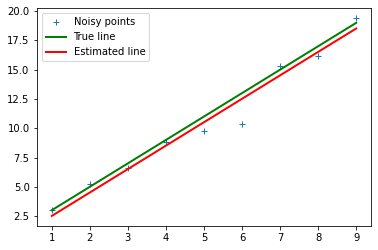

In [31]:
m = 2 # Line equation : y = m*x + c . m i s the s lope . c i s the int e r c ept .
c = 1
x = np . arange (1 ,10 , 1)
np.random.seed(45)
sigma = 1
noise = sigma*np.random.randn(len(x))
o = np.zeros(x.shape)
# o[=1] = 20
y = m*x + c + noise + o

n = len(x)

u11 = np.sum((x - np.mean(x))**2)
u12 = np.sum((x - np.mean(X))*(y - np.mean(y)))
u21 = u12
u22 = np.sum((y - np.mean(y))**2)

U = np.array([[u11, u12], [u21, u22]])
W,V = np.linalg.eig(U)
ev_correspoinding_to_smalest_ev = V[:, np.argmin(W)]

a = ev_correspoinding_to_smalest_ev[0]
b = ev_correspoinding_to_smalest_ev[1]
d = a*np.mean(x) + b*np.mean(y)

mstar = -a/b 
cstar = d/b 

plt.plot(x, y, '+', label='Noisy points')
plt.plot([x[0], x[-1]], [m*x[0]+c, m*x[-1]+c], color='g', linewidth=2, label=r'True line')
plt.plot([x[0], x[-1]], [mstar*x[0]+cstar, mstar*x[-1]+cstar], color='r', linewidth=2, label=r'Estimated line')
plt.legend()
plt.show()

**Q6**. Use RANSAC to fit a line. Experiment on the effect of outliers.